Podaci nisu podijeljeni na train/valid/test

In [1]:
import re
import spacy
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter
nlp = spacy.load(
    "en_core_web_lg"
)
df = pd.read_csv("train_all_tasks.csv")

Svaki redak uzorka sadržava:

In [2]:
print(df.columns)

Index(['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector'], dtype='object')


Broj redaka:

In [3]:
print(df.shape[0])

14000


Radimo s nebalansiranim skupom podataka

Broj redaka iz klase seksistički:

In [4]:
print(len(df[df['label_sexist'] == 'sexist']))

3398


Broj redaka iz klase neseksistički:

In [5]:
print(len(df[df['label_sexist'] == 'not sexist']))

10602


Nema Nan podataka:

In [6]:
print(df.isnull().values.any())

False


In [7]:
najvise = 0
seksisti = []
neseksisti = []
prosrijeci = [0, 0]
djelitelj = [0, 0]
for i in df.itertuples():
    doc = nlp(i.text.lower())
    najvise = max(najvise, len(doc))
    br_rijeci = len(doc)
    tret = [token.lemma_
         for token in doc
         if not token.is_stop and not token.is_punct and token.is_alpha]
    if i.label_sexist == 'sexist':
        prosrijeci[0] += br_rijeci
        djelitelj[0] += 1
        for j in tret:
            seksisti.append(j)
    else:
        prosrijeci[1] += br_rijeci
        djelitelj[1] += 1
        for j in tret:
            neseksisti.append(j)

Najčešće riječi za klasu seksisti:

In [8]:
word_freq = Counter(seksisti)
common_words = word_freq.most_common(5)
for i in common_words:
    print(i)

('woman', 1726)
('man', 729)
('like', 502)
('bitch', 498)
('fuck', 359)


Najčešće riječi za klasu ne seksisti:

In [9]:
word_freq = Counter(neseksisti)
common_words = word_freq.most_common(5)
for i in common_words:
    print(i)

('woman', 2626)
('url', 1516)
('like', 1300)
('girl', 1228)
('man', 1033)


Broj prosječnih riječi: (tokena)
[seksisti, neseksisti]

In [10]:
print(najvise)
prosrijeci[0] /= djelitelj[0]
prosrijeci[1] /= djelitelj[1]
print(prosrijeci)

86
[29.620364920541494, 27.688077721184683]


Razdvojimo na train/valid/test:

In [11]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

lista_tekst = df["text"]
lista_label = df["label_sexist"]

for train_index, test_index in sss.split(lista_tekst, lista_label):
    X_train, X_test = lista_tekst[train_index], lista_tekst[test_index]
    y_train, y_test = lista_label[train_index], lista_label[test_index]
    d_train = {"text": X_train, "label": y_train}
    df_train = pd.DataFrame(d_train)
    d_test = {"text": X_test, "label": y_test}
    df_test = pd.DataFrame(d_test)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=42)

lista_tekst = np.array(df_train["text"])
lista_label = np.array(df_train["label"])

for train_index, valid_index in sss.split(lista_tekst, lista_label):
    X_train, X_valid = lista_tekst[train_index], lista_tekst[valid_index]
    y_train, y_valid = lista_label[train_index], lista_label[valid_index]
    d_train = {"text": X_train, "label": y_train}
    df_train = pd.DataFrame(d_train)
    d_valid = {"text": X_valid, "label": y_valid}
    df_valid = pd.DataFrame(d_valid)

print(len(df_test), len(df_valid), len(df_train))


2800 1400 9800


Pogledajmo [URL], [USER], emoji:

Za [URL]:

In [12]:
urlovi = [0, 0]
sexist_c = len(df_train[df_train['label'] == 'sexist'])
nsexist_c = len(df_train[df_train['label'] == 'not sexist'])
for i in df_train.itertuples():
    kolko = i.text.count("[URL]")
    if i.label == 'sexist':
        urlovi[0] += kolko
    else:
        urlovi[1] += kolko
print(urlovi)
print(urlovi[0] / sexist_c, urlovi[0] / nsexist_c)

[141, 1081]
0.059293523969722456 0.018997574777687955


Za [USER]:

In [13]:
useri = [0, 0]
for i in df_train.itertuples():
    kolko = i.text.count("[USER]")
    if i.label == 'sexist':
        useri[0] += kolko
    else:
        useri[1] += kolko
print(useri)
print(useri[0] / sexist_c, useri[1] / nsexist_c)

[104, 567]
0.04373423044575273 0.07639450282942603


Za emoji:

In [14]:
import re
a_list = ['🤔 🙈 me así, bla es se 😌 ds 💕👭👙']
re.findall(r'[^\w\s,]', a_list[0])

['🤔', '🙈', '😌', '💕', '👭', '👙']

In [18]:
emojiji = [0, 0]
for i in df_train.itertuples():
    doc = nlp(i.text)
    kolko = len(re.findall(r'[^\w\s,]', str(doc)[0]))
    if i.label == 'sexist':
        emojiji[0] += kolko
    else:
        emojiji[1] += kolko
print(emojiji)
print(emojiji[0] / sexist_c, emojiji[1] / nsexist_c)

[118, 614]
0.0496215306980656 0.08272702775532202


SVM + WORD2VEC

In [19]:
from gensim.models import KeyedVectors
from gensim import models
from gensim.utils import simple_preprocess

word2vec_path = 'GoogleNews-vectors-negative300.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary = True)



In [20]:
model.most_similar(positive=["man"])


[('woman', 0.7664012908935547),
 ('boy', 0.6824871301651001),
 ('teenager', 0.6586930155754089),
 ('teenage_girl', 0.6147903203964233),
 ('girl', 0.5921714305877686),
 ('suspected_purse_snatcher', 0.571636438369751),
 ('robber', 0.5585119128227234),
 ('Robbery_suspect', 0.5584409832954407),
 ('teen_ager', 0.5549196600914001),
 ('men', 0.5489763021469116)]

In [21]:
def W2Vvectorize(train):
    corpus_text = '\n'.join(train)
    sentences = corpus_text.split('\n')
    sentences = [line.lower().split(' ') for line in sentences]

    def clean(s):
        return [w.strip(',."!?:;()\'') for w in s]

    sentences = [clean(s) for s in sentences if len(s) > 0]
    vector=[]
    for sent in sentences:
        sent_vec=np.zeros(300)
        count =0
        for word in sent: 
            if word in model:
                vec = model[word]
                sent_vec += vec 
                count += 1
        if count != 0:
            sent_vec /= count #normalize
        vector.append(sent_vec)
    return vector

W2v prije optimizacije hiperparametara:

In [23]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
clf = SVC()

lista_label = np.array(df_train["label"])
lista_label = le.fit_transform(lista_label)

nova_lista = W2Vvectorize(df_train["text"])

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf = clf.fit(nova_lista, lista_label)

In [24]:
print("Training:"+str(clf.score(nova_lista, lista_label)))

lista_label_test = np.array(df_test["label"])
lista_label_test = le.fit_transform(lista_label_test)
nova_lista_test = W2Vvectorize(df_test["text"])

print("Test:"+str(clf.score(nova_lista_test,lista_label_test)))

Training:0.8760204081632653
Test:0.8039285714285714


In [25]:
def evaluate(model, text, y_test, target_names=('not sexist', 'sexist')):
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_fscore_support

    text_features = W2Vvectorize(text)
    y_test_pred = model.predict(text_features)
    print(classification_report(y_test, y_test_pred, target_names=target_names))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="micro")
    print(f"Precision: {precision:6.2f}")
    print(f"   Recall: {recall:6.2f}")
    print(f"       F1: {f1:6.2f}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names)
    plt.show()

              precision    recall  f1-score   support

  not sexist       0.81      0.97      0.88      2120
      sexist       0.75      0.29      0.42       680

    accuracy                           0.80      2800
   macro avg       0.78      0.63      0.65      2800
weighted avg       0.80      0.80      0.77      2800

Precision:   0.80
   Recall:   0.80
       F1:   0.80


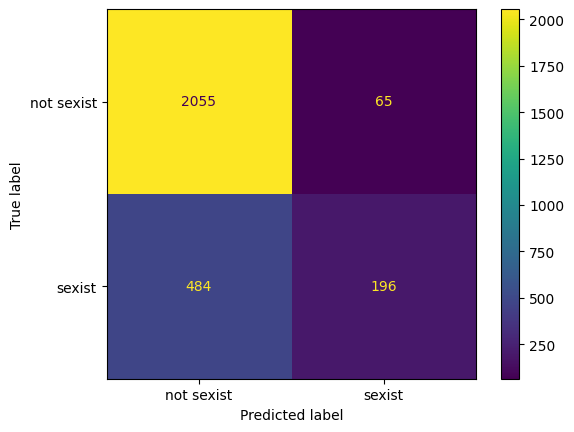

In [26]:
evaluate(clf, df_test.text, lista_label_test)

W2v poslije optimizacije hiperparametara:

Tražimo na train i provjeravamo nad valid?

In [58]:
lista_label = np.array(df_train["label"])
lista_label = le.fit_transform(lista_label)

nova_lista = W2Vvectorize(df_train["text"])

In [30]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(nova_lista, lista_label)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.758 total time=   5.3s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.758 total time=   5.4s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.758 total time=   5.4s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.757 total time=   5.5s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.758 total time=   5.6s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.767 total time=   5.7s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.765 total time=   5.8s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.766 total time=   5.8s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.763 total time=   5.8s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.766 total time=   5.8s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.758 total time=   7.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rb

[CV 2/5] END .......C=1, gamma=1, kernel=linear;, score=0.767 total time=   5.7s
[CV 3/5] END .......C=1, gamma=1, kernel=linear;, score=0.768 total time=   5.3s
[CV 4/5] END .......C=1, gamma=1, kernel=linear;, score=0.766 total time=   5.1s
[CV 5/5] END .......C=1, gamma=1, kernel=linear;, score=0.770 total time=   5.3s
[CV 1/5] END .........C=1, gamma=1, kernel=poly;, score=0.783 total time=   5.8s
[CV 2/5] END .........C=1, gamma=1, kernel=poly;, score=0.796 total time=   5.8s
[CV 3/5] END .........C=1, gamma=1, kernel=poly;, score=0.793 total time=   5.7s
[CV 4/5] END .........C=1, gamma=1, kernel=poly;, score=0.783 total time=   5.4s
[CV 5/5] END .........C=1, gamma=1, kernel=poly;, score=0.799 total time=   4.9s
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.789 total time=   5.5s
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.807 total time=   5.4s
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.805 total time=   5.9s
[CV 4/5] END ..........C=1, 

[CV 4/5] END ......C=10, gamma=1, kernel=linear;, score=0.770 total time=   5.5s
[CV 5/5] END ......C=10, gamma=1, kernel=linear;, score=0.779 total time=   5.7s
[CV 1/5] END ........C=10, gamma=1, kernel=poly;, score=0.769 total time=   5.7s
[CV 2/5] END ........C=10, gamma=1, kernel=poly;, score=0.790 total time=   5.7s
[CV 3/5] END ........C=10, gamma=1, kernel=poly;, score=0.791 total time=   5.7s
[CV 4/5] END ........C=10, gamma=1, kernel=poly;, score=0.785 total time=   5.8s
[CV 5/5] END ........C=10, gamma=1, kernel=poly;, score=0.803 total time=   5.8s
[CV 1/5] END .........C=10, gamma=1, kernel=rbf;, score=0.785 total time=   6.4s
[CV 2/5] END .........C=10, gamma=1, kernel=rbf;, score=0.811 total time=   6.4s
[CV 3/5] END .........C=10, gamma=1, kernel=rbf;, score=0.815 total time=   6.4s
[CV 4/5] END .........C=10, gamma=1, kernel=rbf;, score=0.799 total time=   6.7s
[CV 5/5] END .........C=10, gamma=1, kernel=rbf;, score=0.821 total time=   6.4s
[CV 1/5] END .....C=10, gamm

[CV 1/5] END .......C=100, gamma=1, kernel=poly;, score=0.751 total time=   8.5s
[CV 2/5] END .......C=100, gamma=1, kernel=poly;, score=0.767 total time=   8.8s
[CV 3/5] END .......C=100, gamma=1, kernel=poly;, score=0.764 total time=   9.1s
[CV 4/5] END .......C=100, gamma=1, kernel=poly;, score=0.758 total time=  12.6s
[CV 5/5] END .......C=100, gamma=1, kernel=poly;, score=0.763 total time=  11.3s
[CV 1/5] END ........C=100, gamma=1, kernel=rbf;, score=0.761 total time=  10.7s
[CV 2/5] END ........C=100, gamma=1, kernel=rbf;, score=0.786 total time=  10.4s
[CV 3/5] END ........C=100, gamma=1, kernel=rbf;, score=0.783 total time=  11.4s
[CV 4/5] END ........C=100, gamma=1, kernel=rbf;, score=0.777 total time=  10.7s
[CV 5/5] END ........C=100, gamma=1, kernel=rbf;, score=0.780 total time=  12.4s
[CV 1/5] END ....C=100, gamma=1, kernel=sigmoid;, score=0.650 total time=   4.9s
[CV 2/5] END ....C=100, gamma=1, kernel=sigmoid;, score=0.652 total time=   5.0s
[CV 3/5] END ....C=100, gamm

[CV 3/5] END ......C=1000, gamma=1, kernel=poly;, score=0.764 total time=   9.0s
[CV 4/5] END ......C=1000, gamma=1, kernel=poly;, score=0.758 total time=  12.4s
[CV 5/5] END ......C=1000, gamma=1, kernel=poly;, score=0.764 total time=  12.0s
[CV 1/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.761 total time=  10.2s
[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.786 total time=  10.5s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.780 total time=  10.5s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.776 total time=  12.8s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.780 total time=  10.2s
[CV 1/5] END ...C=1000, gamma=1, kernel=sigmoid;, score=0.649 total time=   4.0s
[CV 2/5] END ...C=1000, gamma=1, kernel=sigmoid;, score=0.651 total time=   4.5s
[CV 3/5] END ...C=1000, gamma=1, kernel=sigmoid;, score=0.620 total time=   3.8s
[CV 4/5] END ...C=1000, gamma=1, kernel=sigmoid;, score=0.644 total time=   5.4s
[CV 5/5] END ...C=1000, gamm

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=3)

In [32]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, gamma=1)


In [74]:
lista_label = np.array(df_valid["label"])
lista_label = le.fit_transform(lista_label)
nova_lista = W2Vvectorize(df_valid["text"])

clf = make_pipeline(StandardScaler(), SVC(class_weight='balanced', C=10, gamma=1, kernel='rbf'))
clf.fit(nova_lista, lista_label)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, class_weight='balanced', gamma=1))])

In [69]:
print("Valid:"+str(clf.score(nova_lista, lista_label)))

lista_label_train = np.array(df_train["label"])
lista_label_train = le.fit_transform(lista_label_train)
nova_lista_train = W2Vvectorize(df_train["text"])

print("Training:"+str(clf.score(nova_lista_train, lista_label_train)))


Valid:1.0
Training:0.7573469387755102


In [70]:
def evaluate(model, text, y_test, target_names=('not sexist', 'sexist')):
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_fscore_support

    text_features = W2Vvectorize(text)
    y_test_pred = model.predict(text_features)
    print(classification_report(y_test, y_test_pred, target_names=target_names))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="micro")
    print(f"Precision: {precision:6.2f}")
    print(f"   Recall: {recall:6.2f}")
    print(f"       F1: {f1:6.2f}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names)
    plt.show()

              precision    recall  f1-score   support

  not sexist       1.00      1.00      1.00      1060
      sexist       1.00      1.00      1.00       340

    accuracy                           1.00      1400
   macro avg       1.00      1.00      1.00      1400
weighted avg       1.00      1.00      1.00      1400

Precision:   1.00
   Recall:   1.00
       F1:   1.00


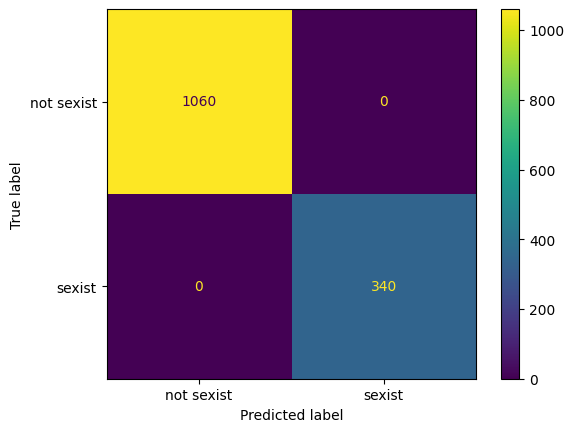

In [71]:
evaluate(clf, df_valid.text, lista_label)

In [75]:
import pickle
word2vec_clf = pickle.dumps(clf)

SVM +TF_IDF

TF_IDF prije optimizacije parametara:

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df_train["text"]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

le = LabelEncoder()
clf = SVC()

lista_label = np.array(df_train["label"])
lista_label = le.fit_transform(lista_label)

clf = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto'))
clf = clf.fit(X, lista_label)

In [38]:
print("Training:"+str(clf.score(X, lista_label)))

lista_label_test = np.array(df_test["label"])
lista_label_test = le.transform(lista_label_test)
nova_lista_test = vectorizer.transform(df_test["text"])

print("Test:"+str(clf.score(nova_lista_test,lista_label_test)))

Training:0.9171428571428571
Test:0.7610714285714286


In [39]:
def evaluate(model, tf_idf, text, y_test, target_names=('not sexist', 'sexist')):
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_fscore_support

    text_features = tf_idf.transform(text)
    y_test_pred = model.predict(text_features)
    print(classification_report(y_test, y_test_pred, target_names=target_names))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="micro")
    print(f"Precision: {precision:6.2f}")
    print(f"   Recall: {recall:6.2f}")
    print(f"       F1: {f1:6.2f}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names)
    plt.show()

              precision    recall  f1-score   support

  not sexist       0.76      1.00      0.86      2120
      sexist       0.92      0.02      0.03       680

    accuracy                           0.76      2800
   macro avg       0.84      0.51      0.45      2800
weighted avg       0.80      0.76      0.66      2800

Precision:   0.76
   Recall:   0.76
       F1:   0.76


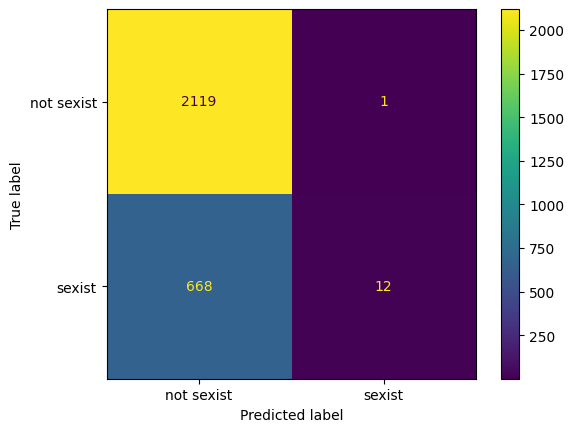

In [40]:
evaluate(clf, vectorizer, df_test.text, lista_label_test)

TF_IDF nakon optimizacije hiperparametara:

Opet treniramo na train i provjeravamo na valid?

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
le = LabelEncoder()

lista_label = np.array(df_train["label"])
lista_label = le.fit_transform(lista_label)
nova_lista = vectorizer.fit_transform(df_train["text"])

In [42]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100], #maknuo C = 1000 jer traje predugo
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(nova_lista, lista_label)


# from sklearn.feature_extraction.text import CountVectorizer
# import sklearn.pipeline

# pipeline = sklearn.pipeline.Pipeline([
#            ('vect', TfidfVectorizer()),
#            ('clf', SVC()),
# ])

# parameters = [{
#     'vect__max_df': (0.5, 0.75, 1.0),
#     'vect__max_features': (None, 5000, 10000, 50000),
#     'vect__ngram_range': ((1, 1), (1, 2), (1,3)),  
#     'tfidf__use_idf': (True, False),
#     'tfidf__norm': ('l1', 'l2', None),
#     'clf__max_iter': (20,),
#     'clf__alpha': (0.00001, 0.000001),
#     'clf__penalty': ('l2', 'elasticnet'),
#     'clf__max_iter': (10, 50, 80)},
# 	{
#     'vect': (CountVectorizer(),)
#     # count_vect_params...
#     'clf__max_iter': (20,),
#     'clf__alpha': (0.00001, 0.000001),
#     'clf__penalty': ('l2', 'elasticnet'),
#     'clf__max_iter': (10, 50, 80)
# }]

# grid_search = GridSearchCV(pipeline, parameters)

# # fitting the model for grid search
# grid.fit(nova_lista, lista_label)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.765 total time=   6.2s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.767 total time=   6.2s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.765 total time=   6.3s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.763 total time=   6.2s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.764 total time=   6.3s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.758 total time=   9.7s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.758 total time=   9.7s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.757 total time=   9.6s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.757 total time=   9.6s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.757 total time=   9.7s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.758 total time=   8.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf

[CV 2/5] END .......C=1, gamma=1, kernel=linear;, score=0.838 total time=   6.0s
[CV 3/5] END .......C=1, gamma=1, kernel=linear;, score=0.828 total time=   6.1s
[CV 4/5] END .......C=1, gamma=1, kernel=linear;, score=0.827 total time=   6.1s
[CV 5/5] END .......C=1, gamma=1, kernel=linear;, score=0.837 total time=   6.3s
[CV 1/5] END .........C=1, gamma=1, kernel=poly;, score=0.758 total time=  10.9s
[CV 2/5] END .........C=1, gamma=1, kernel=poly;, score=0.759 total time=  10.8s
[CV 3/5] END .........C=1, gamma=1, kernel=poly;, score=0.757 total time=  10.8s
[CV 4/5] END .........C=1, gamma=1, kernel=poly;, score=0.758 total time=  10.7s
[CV 5/5] END .........C=1, gamma=1, kernel=poly;, score=0.757 total time=  10.6s
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.798 total time=   9.0s
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.822 total time=   8.9s
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.809 total time=   9.0s
[CV 4/5] END ..........C=1, 

[CV 4/5] END ......C=10, gamma=1, kernel=linear;, score=0.790 total time=   5.9s
[CV 5/5] END ......C=10, gamma=1, kernel=linear;, score=0.802 total time=   6.0s
[CV 1/5] END ........C=10, gamma=1, kernel=poly;, score=0.759 total time=  17.4s
[CV 2/5] END ........C=10, gamma=1, kernel=poly;, score=0.761 total time=  17.5s
[CV 3/5] END ........C=10, gamma=1, kernel=poly;, score=0.759 total time=  17.5s
[CV 4/5] END ........C=10, gamma=1, kernel=poly;, score=0.760 total time=  17.6s
[CV 5/5] END ........C=10, gamma=1, kernel=poly;, score=0.759 total time=  17.4s
[CV 1/5] END .........C=10, gamma=1, kernel=rbf;, score=0.818 total time=  12.1s
[CV 2/5] END .........C=10, gamma=1, kernel=rbf;, score=0.828 total time=  12.2s
[CV 3/5] END .........C=10, gamma=1, kernel=rbf;, score=0.826 total time=  12.4s
[CV 4/5] END .........C=10, gamma=1, kernel=rbf;, score=0.822 total time=  12.2s
[CV 5/5] END .........C=10, gamma=1, kernel=rbf;, score=0.834 total time=  12.3s
[CV 1/5] END .....C=10, gamm

[CV 1/5] END .......C=100, gamma=1, kernel=poly;, score=0.759 total time=  19.0s
[CV 2/5] END .......C=100, gamma=1, kernel=poly;, score=0.761 total time=  18.9s
[CV 3/5] END .......C=100, gamma=1, kernel=poly;, score=0.759 total time=  16.7s
[CV 4/5] END .......C=100, gamma=1, kernel=poly;, score=0.760 total time=  16.2s
[CV 5/5] END .......C=100, gamma=1, kernel=poly;, score=0.759 total time=  18.7s
[CV 1/5] END ........C=100, gamma=1, kernel=rbf;, score=0.818 total time=  12.0s
[CV 2/5] END ........C=100, gamma=1, kernel=rbf;, score=0.828 total time=  12.2s
[CV 3/5] END ........C=100, gamma=1, kernel=rbf;, score=0.826 total time=  12.4s
[CV 4/5] END ........C=100, gamma=1, kernel=rbf;, score=0.822 total time=  12.2s
[CV 5/5] END ........C=100, gamma=1, kernel=rbf;, score=0.834 total time=  12.3s
[CV 1/5] END ....C=100, gamma=1, kernel=sigmoid;, score=0.753 total time=  19.4s
[CV 2/5] END ....C=100, gamma=1, kernel=sigmoid;, score=0.745 total time=  12.4s
[CV 3/5] END ....C=100, gamm

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=3)

In [43]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


{'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}
SVC(C=10, gamma=0.1, kernel='sigmoid')


In [44]:
corpus = df_valid["text"]
X = vectorizer.fit_transform(corpus)

In [72]:
lista_label = np.array(df_valid["label"])
lista_label = le.fit_transform(lista_label)

clf = make_pipeline(SVC(class_weight='balanced', C=10, gamma=0.1, kernel='sigmoid'))
clf = clf.fit(X, lista_label)


In [46]:
print("Valid:"+str(clf.score(X, lista_label)))

lista_label_train = np.array(df_train["label"])
lista_label_train = le.transform(lista_label_train)
nova_lista_train = vectorizer.transform(df_train["text"])

print("Training:"+str(clf.score(nova_lista_train,lista_label_train)))

Valid:0.9714285714285714
Training:0.7491836734693877


In [47]:
def evaluate(model, tf_idf, text, y_test, target_names=('not sexist', 'sexist')):
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_fscore_support

    text_features = tf_idf.transform(text)
    y_test_pred = model.predict(text_features)
    print(classification_report(y_test, y_test_pred, target_names=target_names))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="micro")
    print(f"Precision: {precision:6.2f}")
    print(f"   Recall: {recall:6.2f}")
    print(f"       F1: {f1:6.2f}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names)
    plt.show()

              precision    recall  f1-score   support

  not sexist       1.00      0.97      0.98      1060
      sexist       0.90      0.99      0.94       340

    accuracy                           0.97      1400
   macro avg       0.95      0.98      0.96      1400
weighted avg       0.97      0.97      0.97      1400

Precision:   0.97
   Recall:   0.97
       F1:   0.97


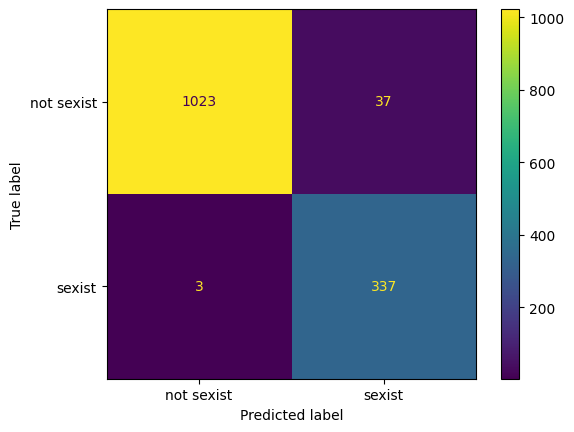

In [48]:
evaluate(clf, vectorizer, df_valid.text, lista_label)

In [73]:
import pickle
tfidf_clf = pickle.dumps(clf)

In [81]:
load_w2v_clf = pickle.loads(word2vec_clf)
tekst = "hate all women"
tekst_v = W2Vvectorize(tekst)
if round(np.mean(load_w2v_clf.predict(tekst_v))) == 1: print('sexist')
else: print('not sexist')

not sexist


In [87]:
load_tfidf_clf = pickle.loads(tfidf_clf)
tekst = "women are the best thing"
tekst_v = vectorizer.transform([tekst])
if round(np.mean(load_tfidf_clf.predict(tekst_v))) == 1: print('sexist')
else: print('not sexist')

not sexist
